## **Machine Learning 1 - Comparativo entre Random Forest e KNN (K-Nearest Neighbors)**

**Realizado por:**
Artur Stein - 1116023

Para esse estudo comparativo entre modelos de classificação, será utilizado o dataset **penguins**, um dataset de estudo disponibilizado pelo **Seaborn**. Com a seguinte estrutura:

|Coluna|Descrição|Tipo|
|-|-|-|
|species|Fator que denota a espécie do pinguim (Adélie, Chinstrap and Gentoo)|Categórica|
|island|Fator que denota a ilha em que se encontra|Categórica|
|bill_length_mm|Fator que denota o comprimento do bico em milímetros|Numérica|
|bill_depth_mm|Fator que denota a profundidade do bico em milímetros|Numérica|
|flipper_length_mm|Fator que denota o comprimento da nadadeira em milímetros|Numérica|
|body_mass_g|Fator que denota o peso do pinguim em gramas|Numérica|
|sex|Fator que denota o sexo do pinguim|Categórica|

O dataset pode ser importado:
- Do comando pelo Seaborn *load_dataset('penguins')*;
- Baixando o CSV no [Kaggle](https://www.kaggle.com/datasets/larsen0966/penguins).

O objetivo desse projeto é ver se os modelos são capazes de classificar a espécie dos pinguins de forma correta, a fim de avaliar qual dos modelos (Random Forest ou KNN) melhor performa.

### Importação das Bibliotecas

In [28]:
## Algumas funcoes acatariam mudancas futuras no funcionamneto do codigo, mas para uma melhor leitura, esses avisos serao removidos.

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


### Análise Inicial dos Dados

In [4]:
penguins = sns.load_dataset('penguins')

In [5]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [6]:
for col in penguins.columns:
  qtd_unique = len(penguins[col].unique())
  perc_nulls = penguins[col].isna().mean()
  print(f'{col}: {qtd_unique} valores únicos, e {100*perc_nulls:.2f}% são nulos')

species: 3 valores únicos, e 0.00% são nulos
island: 3 valores únicos, e 0.00% são nulos
bill_length_mm: 165 valores únicos, e 0.58% são nulos
bill_depth_mm: 81 valores únicos, e 0.58% são nulos
flipper_length_mm: 56 valores únicos, e 0.58% são nulos
body_mass_g: 95 valores únicos, e 0.58% são nulos
sex: 3 valores únicos, e 3.20% são nulos


Devido à baixa quantidade de valores nulos presentes no Dataset e pelo enfoque do trabalho ser uma comparação entre os modelos, esses poucos registros não terão grande impacto na comparação, portanto serão removidos.

In [7]:
penguins = penguins.dropna()

In [8]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Análise Gráfica dos Dados

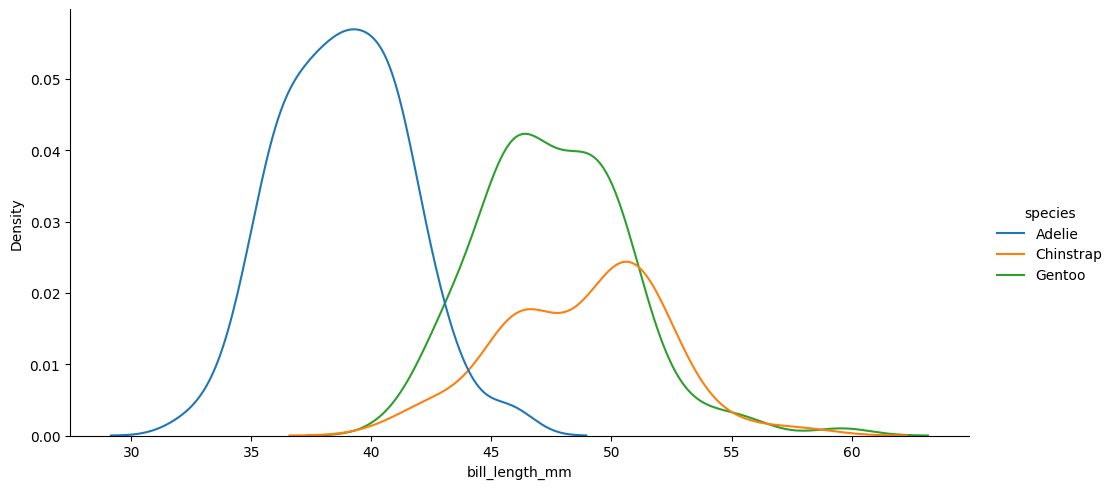

In [9]:
sns.displot(data=penguins, kind='kde', x='bill_length_mm', hue='species', aspect=2)

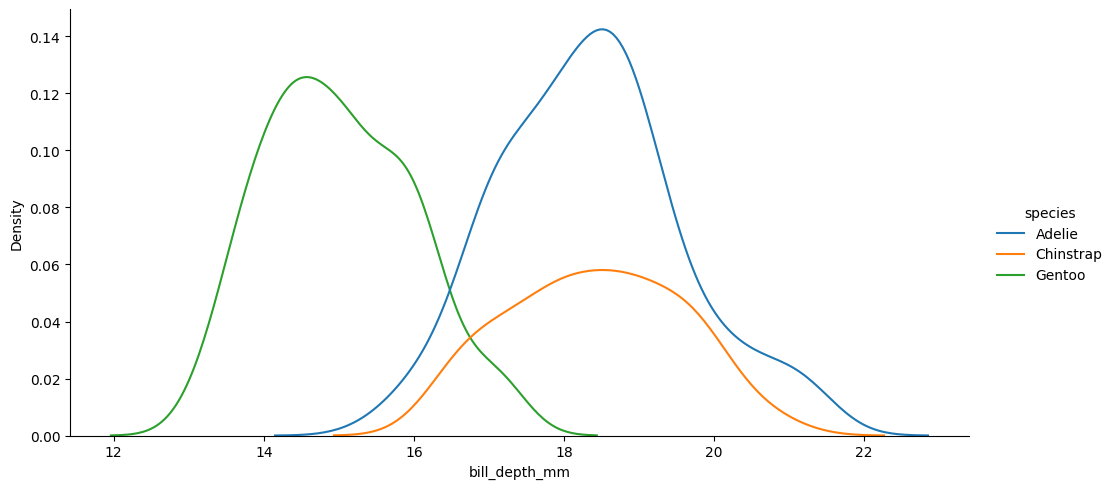

In [10]:
sns.displot(data=penguins, kind='kde', x='bill_depth_mm', hue='species', aspect=2)

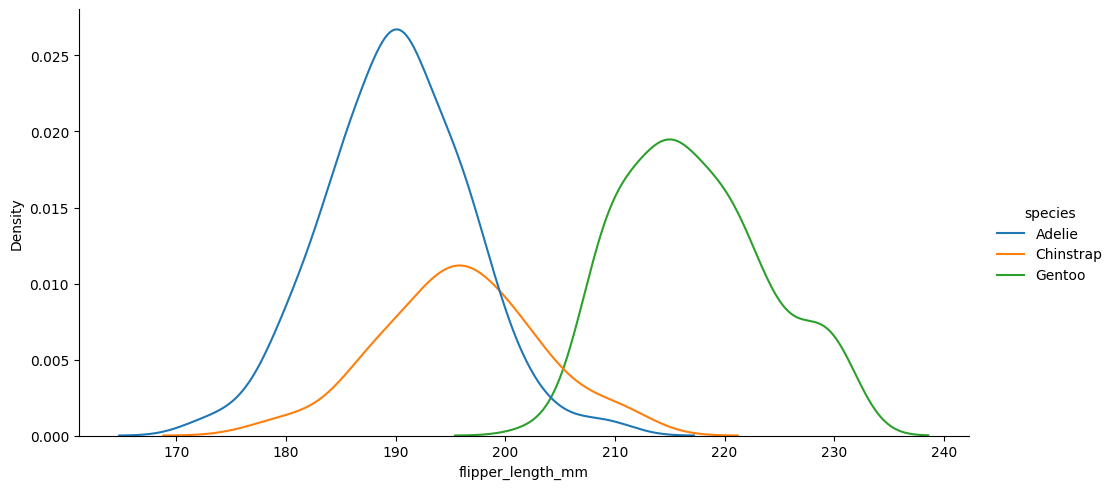

In [11]:
sns.displot(data=penguins, kind='kde', x='flipper_length_mm', hue='species', aspect=2)

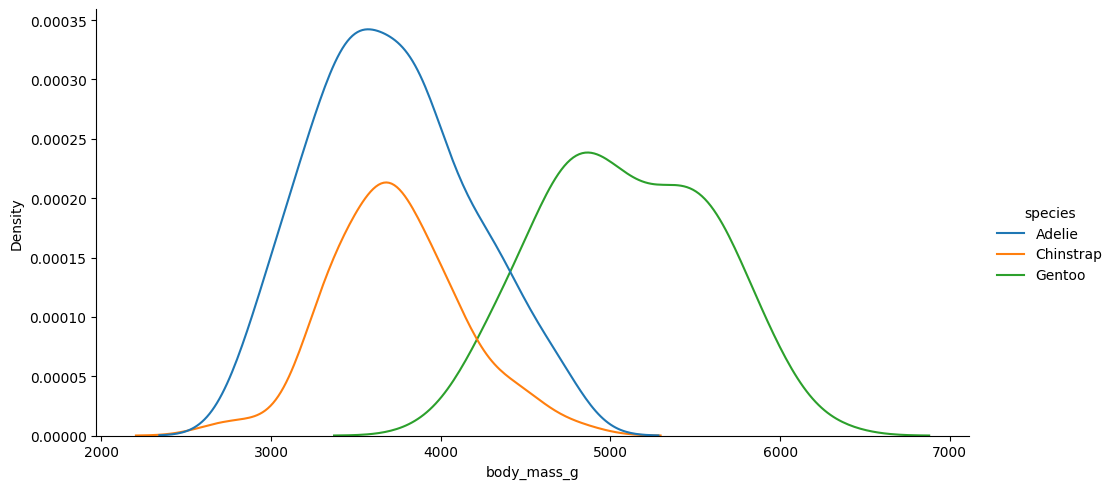

In [12]:
sns.displot(data=penguins, kind='kde', x='body_mass_g', hue='species', aspect=2)

- Adelie e Chinstrap têm massa corporal e profundidade de bico muito semelhantes, enquanto os Gentoo são perceptivelmente mais pesados e têm profundidade média de bico mais baixa. Os Gentoo também tendem a ter as asas mais longas das três espécies.
- Chinstrap e Gentoo são semelhantes em seu comprimento de bico, que geralmente é mais longo do que o dos Adelie.
- Há alguma sobreposição entre os Gentoo e os outros em todas as distribuições, mas a profundidade do bico e o comprimento da asa parecem ter a menor sobreposição.

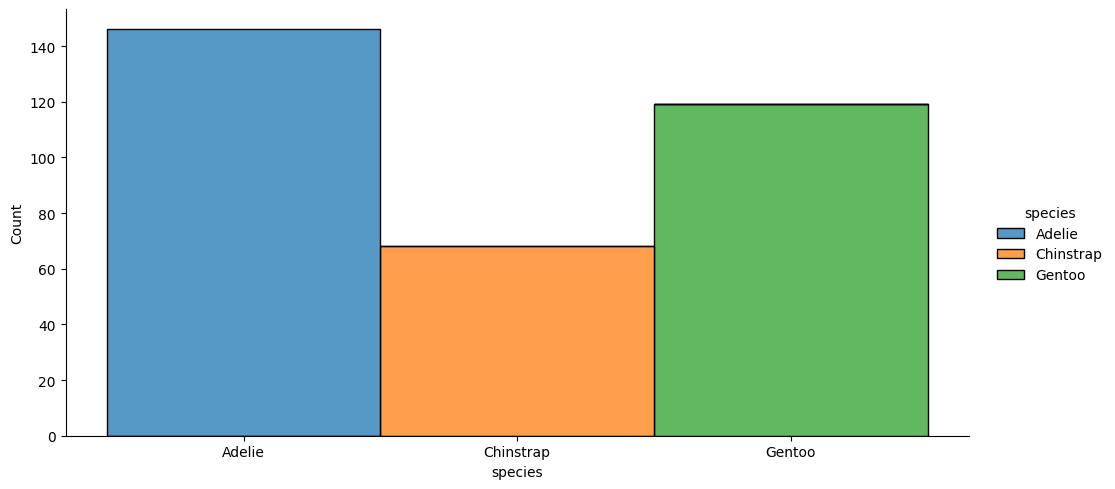

In [13]:
sns.displot(data=penguins, kind='hist', x='species', hue='species', multiple='stack', aspect=2)

In [14]:
penguins['species'].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

### Processamento dos Dados

Como primeiro passo, precisamos tratar nossas colunas categóricas, a fim de serem utilizadas no modelo. Primeiramente, iremos trocar a nossa coluna target por números que irão representar as espécies, como mostra abaixo:
 - Adelie: 1;
 - Chinstrap: 2;
 - Gentoo: 3.

In [15]:
penguins['species'] = penguins['species'].replace({'Adelie': 1, 'Chinstrap': 2,'Gentoo': 3})

A seguir, a nossa coluna target será removida do DataFrame para se fazer o *train_test_split*:

In [16]:
x = penguins.drop('species', axis = 1)
y = penguins['species']

In [17]:
x.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [18]:
y.value_counts()

species
1    146
3    119
2     68
Name: count, dtype: int64

In [19]:
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42)

Em seguida, iremos tratar o restante das nossas colunas categóricas, transformando-as em variáveis *dummy*:

In [20]:
one_hot = OneHotEncoder()

categorical_cols = ['island', 'sex']
X_train_categorical = X_train[categorical_cols]
X_test_categorical = X_test[categorical_cols]

X_train_encoded = one_hot.fit_transform(X_train_categorical)
X_test_encoded = one_hot.transform(X_test_categorical)

encoded_cols = one_hot.get_feature_names_out(categorical_cols)

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoded_cols, index=X_train_categorical.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoded_cols, index=X_test_categorical.index)

X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

X_train_final = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test, X_test_encoded_df], axis=1)

In [21]:
X_train_final.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
230,40.9,13.7,214.0,4650.0,1.0,0.0,0.0,1.0,0.0
84,37.3,17.8,191.0,3350.0,0.0,1.0,0.0,1.0,0.0
303,50.0,15.9,224.0,5350.0,1.0,0.0,0.0,0.0,1.0
22,35.9,19.2,189.0,3800.0,1.0,0.0,0.0,1.0,0.0
29,40.5,18.9,180.0,3950.0,1.0,0.0,0.0,0.0,1.0


### Teste no KNN e Random Forest Default

A fim de testar a eficácia dos modelos, primeiramente executaremos um teste com os valores deafult de ambos, para depois compará-los com uma otimização de parâmetros feita por *GridShearch*.

#### KNN

In [22]:
knn_def_clf = KNeighborsClassifier()
knn_def_clf.fit(X_train_final, y_train)

y_train_pred = knn_def_clf.predict(X_train_final)

y_test_pred = knn_def_clf.predict(X_test_final)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print('Acurácia no conjunto de treinamento:', accuracy_train)
print('Acurácia no conjunto de teste:', accuracy_test, '\n')

print('Matriz de Confusão de treino: ')
print(confusion_matrix(y_train, y_train_pred), "\n")  

print('Matriz de Confusão de teste: ')
print(confusion_matrix(y_test, y_test_pred), "\n")  

Acurácia no conjunto de treinamento: 0.8270676691729323
Acurácia no conjunto de teste: 0.8208955223880597 

Matriz de Confusão de treino: 
[[102   5   8]
 [ 24  28   3]
 [  6   0  90]] 

Matriz de Confusão de teste: 
[[25  2  4]
 [ 5  8  0]
 [ 0  1 22]] 



### Random Forest

In [23]:
dec_tree_def_clf = RandomForestClassifier()
dec_tree_def_clf.fit(X_train_final, y_train)

y_train_pred = dec_tree_def_clf.predict(X_train_final)

y_test_pred = dec_tree_def_clf.predict(X_test_final)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print('Acurácia no conjunto de treinamento:', accuracy_train)
print('Acurácia no conjunto de teste:', accuracy_test, '\n')

print('Matriz de Confusão de treino: ')
print(confusion_matrix(y_train, y_train_pred), "\n")  

print('Matriz de Confusão de teste: ')
print(confusion_matrix(y_test, y_test_pred), "\n")  

Acurácia no conjunto de treinamento: 1.0
Acurácia no conjunto de teste: 1.0 

Matriz de Confusão de treino: 
[[115   0   0]
 [  0  55   0]
 [  0   0  96]] 

Matriz de Confusão de teste: 
[[31  0  0]
 [ 0 13  0]
 [ 0  0 23]] 



Ambos tiveram uma boa performace, com uma maior vantagem para o RandomForest, que conseguiu prever tanto em treino quanto em teste com uma acurácia de 1. Já o KNN teve um desempenho inferior, prevendo com uma acurácia em treino e teste de 0,82.

### Melhorando Hiperparâmetros

Para o ajuste de hiperparâmetros será utilizado o *GridSearch*, para garantir um melhor resultado para o KNN e checar quais seriam os hiperparâmetros ideais para o Random Forest.
O *GridSearch* não é recomendado para problemas mais complexos, já que exige um custo computacional alto, mas por ser um dataset de estudo com poucos registros, ainda é uma escolha viável.

In [24]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
  estimator = RandomForestClassifier(),
  param_grid = param_grid_rf,
  cv = 5
)

grid_search.fit(X_train_final, y_train)

random_forest_gs_best_params = grid_search.best_params_
print(random_forest_gs_best_params)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [25]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5
)

grid_search_knn.fit(X_train_final, y_train)

knn_gs_best_params = grid_search_knn.best_params_
print(knn_gs_best_params)

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


Portanto, os hiperparâmetros com melhor desempenho foram:
- KNN: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
- Random Forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

### Teste com os Hiperparâmetros Ajustados

In [26]:
knn_def_clf = KNeighborsClassifier(**knn_gs_best_params)
knn_def_clf.fit(X_train_final, y_train)

y_train_pred = knn_def_clf.predict(X_train_final)

y_test_pred = knn_def_clf.predict(X_test_final)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print('Acurácia no conjunto de treinamento:', accuracy_train)
print('Acurácia no conjunto de teste:', accuracy_test, '\n')


print('Matriz de Confusão de treino: ')
print(confusion_matrix(y_train, y_train_pred), "\n")  

print("Matriz de Confusão de teste: ")
print(confusion_matrix(y_test, y_test_pred), "\n")  

Acurácia no conjunto de treinamento: 1.0
Acurácia no conjunto de teste: 0.8656716417910447 

Matriz de Confusão de treino: 
[[115   0   0]
 [  0  55   0]
 [  0   0  96]] 

Matriz de Confusão de teste: 
[[29  1  1]
 [ 6  7  0]
 [ 1  0 22]] 



In [27]:
random_forest_def_clf = RandomForestClassifier(**random_forest_gs_best_params)
random_forest_def_clf.fit(X_train_final, y_train)

y_train_pred = random_forest_def_clf.predict(X_train_final)

y_test_pred = random_forest_def_clf.predict(X_test_final)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print('Acurácia no conjunto de treinamento:', accuracy_train)
print('Acurácia no conjunto de teste:', accuracy_test, '\n')

print('Matriz de Confusão de treino: ')
print(confusion_matrix(y_train, y_train_pred), "\n")  

print('Matriz de Confusão de teste: ')
print(confusion_matrix(y_test, y_test_pred), "\n")  

Acurácia no conjunto de treinamento: 0.9887218045112782
Acurácia no conjunto de teste: 1.0 

Matriz de Confusão de treino: 
[[113   2   0]
 [  1  54   0]
 [  0   0  96]] 

Matriz de Confusão de teste: 
[[31  0  0]
 [ 0 13  0]
 [ 0  0 23]] 



Com os ajustes, ocorreram algumas mudanças. O KNN apresentou um *overfitting*, tendo seu conjunto de treino com uma acurácia de 1 e seu conjunto de teste, com uma pequena melhora, 0,86. Já o Random Forest, apresentou praticamente os mesmos resultados, apenas teve alguns registros de treino classificados de forma errada, mas teve 100% de acertividade no conjunto de teste.

### Conclusões

Concluímos que o Random Forest apresentou um desempenho superior neste conjunto de dados, com uma taxa de classificação de quase 100%. Enquanto isso, o KNN demonstrou um desempenho satisfatório, porém foi superado pelo Random Forest.